# Northbrae and Burdell Mountain Volcanics date bar plots

This notebook generates the date bar plot associated with U-Pb dates for the Northbrae and Burdell Mountain Volcanics.

## Import scientific Python libraries for plotting

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

params = {'ytick.labelsize':'large'}
plt.rcParams.update(params)

%config InlineBackend.figure_format='retina'
%matplotlib inline

## Define functions to calculate weighted means and generate date bar plot

In [2]:
def weighted_mean(dates,sigma):
    
    """
    calculated a weighted mean from dates and uncertainities
    
    input parameters
    ----------------
    dates: date of individual grains
    sigma: 1σ uncertainty associated with dates
    
    returns
    ----------------
    weighted_mean, 1σ uncertainty
    
    """
    
    inverse_variance=[]
    alpha=[]
    weighted_mean_calc=[]
    
    for n in range(0,len(dates)):
        value = 1/sigma[n]**2
        inverse_variance.append(value)
    inverse_variance_sum = np.sum(inverse_variance)
    
    for n in range(0,len(dates)):
        value = (1/sigma[n]**2)/inverse_variance_sum
        alpha.append(value)
        
    #calculate the weights for each date    
    for n in range(0,len(dates)):
        value = alpha[n]*dates[n]
        weighted_mean_calc.append(value)
    
    #take the sum of the weights multiplied by the dates to get the weighted
    #mean (equation 64 of McLean et al., 2011)
    weighted_mean = np.sum(weighted_mean_calc)
    
    #the variance of the weighted mean is simply the inverse of the sum of
    #the inverse variances of each date (equation 66 of McLean et al., 2011)
    variance = 1/inverse_variance_sum
    
    weighted_mean_sigma = np.sqrt(variance)
    
    n = len(dates)
    
    print('The weighted mean is:')

    print(weighted_mean)

    print('With a 2sigma error of:')

    print(2*weighted_mean_sigma)
    
    print('N=' )
    print(n)
    
    return weighted_mean, 2*weighted_mean_sigma

def plot_dates(zircon_means, zircon_2sigmas, include, sample_means, sample_2sigmas, colours, labels,\
               legend=True,figsize=None, ylim=None, lineweight=None, bbox_to_anchor=None):
    """
    Make a date distribution plot.
    
    inputs:
    - zircon_means = list of numpy arrays containing mean dates (each array being a sample)
    - zircon_2sigmas = list of numpy arrays containing 2sigmas (each array being a sample)
    - include = list of 'yes' or 'no' array for inclusion in mean (each array being a sample)
    - sample_means = list of sample mean dates (one per sample)
    - sample_2sigmas = list of sample 2sigmas (one per sample)
    - colours = list of colours (one per sample)
    - labels = list of labels (one per sample)
    - figsize = figure size (optional)
    - ylim = ylim (optional)
    - linewidth = zircon linewidth (optional)
    - bbox_to_anchor = for the legend (optional)
    """
    # formatting constants
    zircon_spacing = 0.9
    sample_spacing = 4 - zircon_spacing
    start_x = 3
    yes_alpha = 0.8
    no_alpha = 0.2
    x_positions = []
    if lineweight==None:
        lineweight=3
    
    # initialize current x
    current_x = start_x
    
    # number of samples
    n_samples = len(zircon_means)
    
    # plot
    if figsize == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    # iterate over each sample
    for i in range(n_samples):
        
        # number of zircons in sample
        n_zircons = len(zircon_means[i])
        
        # sample width
        sample_width = zircon_spacing*n_zircons
        
        # the 2sigma uncertainty on the sample age
        if sample_2sigmas != None:
            rectangle = matplotlib.patches.Rectangle((current_x, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)
            
        # the mean age
        if sample_means != None:
            ax.hlines(sample_means[i], current_x, current_x+sample_width,colors='C2')
            
        # legend control
        marked = False
        
        # iterate over each zircon
        for j in range(n_zircons):
            
            if marked:
                if include[i][j] == 'yes':
                    ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                              colors=colours[i], lw=lineweight, alpha=yes_alpha)
                else:
                    ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
            else:
                if include[i][j] == 'yes':
                    ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                              colors=colours[i], lw=lineweight, alpha=yes_alpha, label=labels[i])
                    marked = True
                else:
                    ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
                
            # tick the x to the next zircon
            current_x = current_x + zircon_spacing
        
        # tick the x to the next sample
        current_x = current_x + sample_spacing
        x_positions.append(current_x-sample_spacing)
    
    # prettify
    ax.invert_yaxis()
    ax.set_ylabel('age (Ma)',fontsize=16)
    if legend == True:
        if bbox_to_anchor == None:
            ax.legend(bbox_to_anchor=(1.8,1), fontsize=12)
        else:
            ax.legend(bbox_to_anchor=bbox_to_anchor, fontsize=12)
    if ylim != None:
        ax.set_ylim(ylim)
        
    return fig, ax, x_positions

## Import U-Pb geochronology data

MT24_1 are $^{206}$Pb/$^{238}$U dates developed via CA-ID-TIMS at Boise State University from Gerasimov et al. 2023.

In [3]:
MT24_1_datafile = 'https://raw.githubusercontent.com/Swanson-Hysell-Group/Gerasimov_Berkeley_Hills/main/data/CA_ID_TIMS/MT24_1/MT24_1_dates.csv'

MT24_1 = pd.read_csv(MT24_1_datafile)
MT24_1.sort_values('206Pb/238U', inplace=True, ascending=False)
MT24_1.reset_index(inplace=True)

BM22_1 and IR22_1 are $^{206}$Pb/$^{238}$U dates developed via LA-ICP-MS at Boise State University from Henschel et al. 20##.

## Calculate weighted means

In [4]:
MT24_1_filtered = MT24_1[MT24_1['include']=='yes']
MT24_1_filtered.reset_index(inplace=True)
MT24_1_date, MT24_1_2sigma = weighted_mean(MT24_1_filtered['206Pb/238U'],MT24_1_filtered['206Pb/238U_2sigma']/2)

The weighted mean is:
9.973626437282388
With a 2sigma error of:
0.00808772030046732
N=
4


## Specify Ar-Ar dates

Ar-Ar dates associated with the Burdell Mountain

Ar-Ar dates associated with the Berkeley Hills Volcanics were published in Wagner et al. 2021. The dates were developed by Al Deino at the Berkeley Geochronology Center. The Moraga Tuff synonymous with their "Berkeley Hills Tuff" and the Siesta Tuff is within lacustrine sediments of the Siesta Formation above the Moraga Formation.

In [5]:
#date developed on sanidine phenocrysts (Wagner et al. 2021)
Moraga_Tuff_Ar_date = 9.8356
Moraga_Tuff_Ar_2sigma = 0.0076*2

#date developed on plagioclase phenocrysts (Wagner et al. 2021)
Siesta_Tuff_Ar_date = 9.644
Siesta_Tuff_Ar_2sigma = 0.089*2

In [6]:
#date developed on zircon U-Pb (Gersimov et al. 2022)
MT24_1_Age = 9.974
MT24_1_2Sigma = 0.014

In [7]:
#date developed on plagioclase phenocrysts (Wagner et al. 2011)
Burdell_Mountain_Ar_date_RFBM_7 = 11.07
Burdell_Mountain_Ar_2sigma_RFBM_7 = 0.04*2

Burdell_Mountain_Ar_date_RFBM_8 = 10.99
Burdell_Mountain_Ar_2sigma_RFBM_8 = 0.08*2

Burdell_Mountain_Ar_date_RFBM_9 = 10.59
Burdell_Mountain_Ar_2sigma_RFBM_9 = 0.15*2

Burdell_Mountain_Ar_date_RFBM_10 = 11.18
Burdell_Mountain_Ar_2sigma_RFBM_10 = 0.05*2

In [89]:
#date developed on biotite, hornblende, and k-spar phenocrysts (Drinkwater 1992)

# Quien Sabe K-Ar dates
Quien_Sabe_K_Ar_date_85Sg_6 = 9.33
Quien_Sabe_K_Ar_date_84Sg_8b = 9.52
Quien_Sabe_K_Ar_date_84Sg_3 = 9.82
Quien_Sabe_K_Ar_date_84Sg_6b = 9.91
Quien_Sabe_K_Ar_date_84Sg_6a = 9.95
Quien_Sabe_K_Ar_date_81JD_23 = 10
Quien_Sabe_K_Ar_date_86Sg_9 = 10
Quien_Sabe_K_Ar_date_84Sg_8a = 10.1
Quien_Sabe_K_Ar_date_86Sg_8 = 10.1
Quien_Sabe_K_Ar_date_81JD_71 = 10.7
Quien_Sabe_K_Ar_date_89Sg_15 = 11.2
Quien_Sabe_K_Ar_date_88Sg_12 = 11.6

# Quien Sabe K-Ar 2sigma
Quien_Sabe_K_Ar_2sigma_85Sg_6 = 0.13*2
Quien_Sabe_K_Ar_2sigma_84Sg_8b = 0.4*2
Quien_Sabe_K_Ar_2sigma_84Sg_3 = 0.4*2
Quien_Sabe_K_Ar_2sigma_84Sg_6b = 0.5*2
Quien_Sabe_K_Ar_2sigma_84Sg_6a = 3.35*2
Quien_Sabe_K_Ar_2sigma_81JD_23 = 0.25*2
Quien_Sabe_K_Ar_2sigma_86Sg_9 = 0.17*2
Quien_Sabe_K_Ar_2sigma_84Sg_8a = 5.15*2
Quien_Sabe_K_Ar_2sigma_86Sg_8 = 0.14*2
Quien_Sabe_K_Ar_2sigma_81JD_71 = 0.27*2
Quien_Sabe_K_Ar_2sigma_89Sg_15 = 0.3*2
Quien_Sabe_K_Ar_2sigma_88Sg_12 = 0.15*2

In [15]:
#date developed on zircon U-Pb (Henschel et al., 202#)
Burdell_Mountain_weighted_mean_date = 11.01
Burdell_Mountain_weighted_mean_2sigma = 0.1

Indian_Rock_weighted_mean_date = 11.095
Indian_Rock_weighted_mean_2sigma = 0.088

In [10]:
zircon_means = [MT24_1['206Pb/238U']]
zircon_2sigmas = [MT24_1['206Pb/238U_2sigma']]
include = [MT24_1['include']]
sample_means = [MT24_1_date]
sample_2sigmas = [MT24_1_2sigma]
colors = ['black']
labels = ['Moraga Tuff']

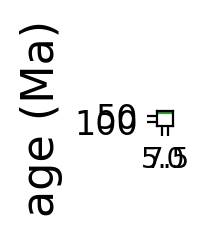

In [75]:
fig, ax, x_positions = plot_dates(zircon_means, zircon_2sigmas, 
                                  include, sample_means, sample_2sigmas, 
                                  colors, labels, legend=False, figsize=(0.1,0.1),lineweight=6)

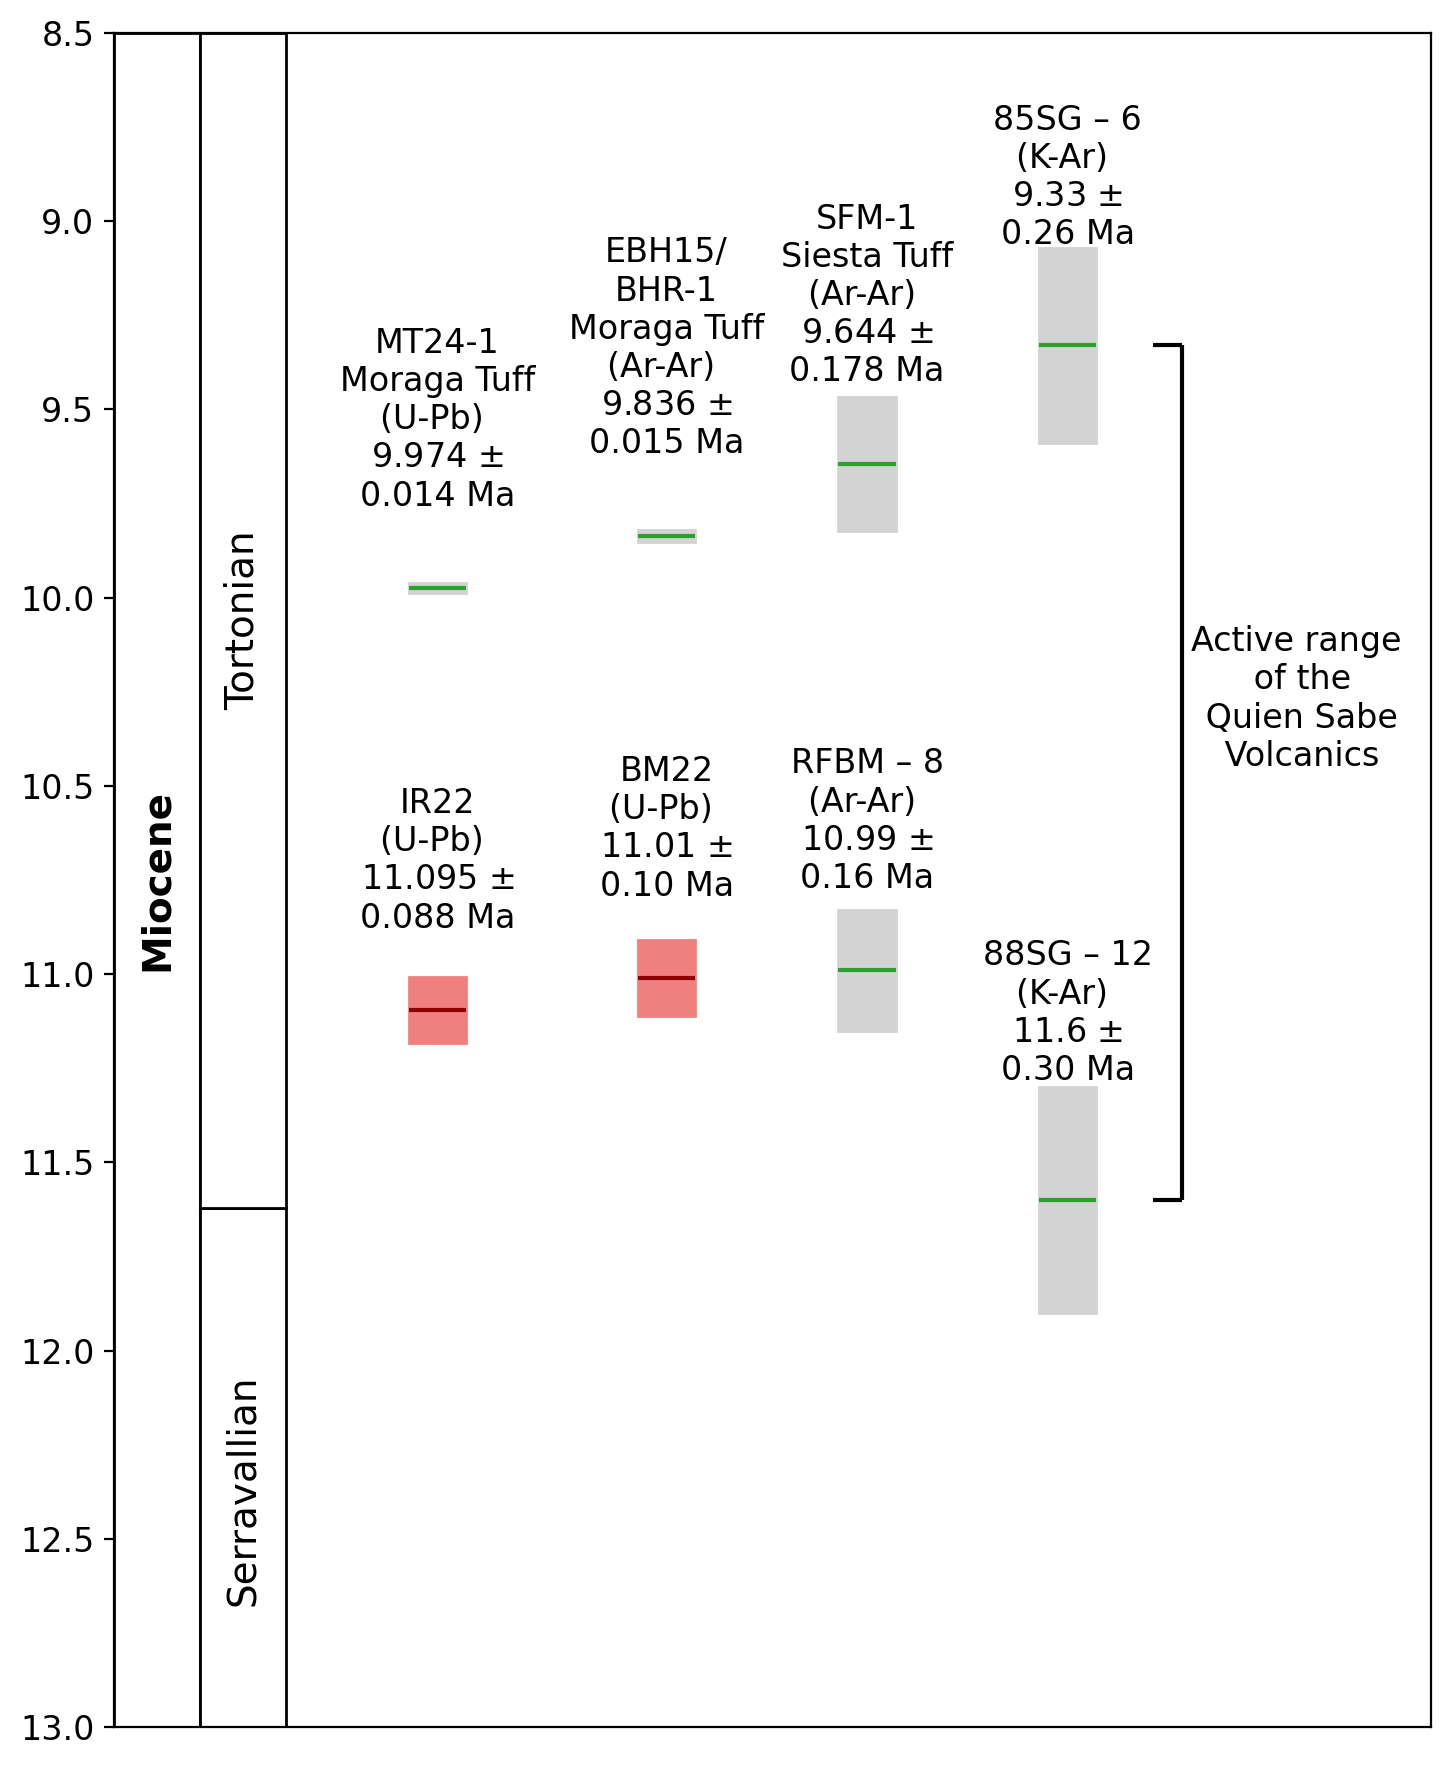

In [71]:
plot_age_min = 8.5
plot_age_max = 13

fig, ax = plt.subplots(figsize=(8.5,11))


### Moraga Tuff dates
Ar_x=x_positions[0]-5
Ar_width = 2
ax.hlines(MT24_1_Age,Ar_x,Ar_x+Ar_width,color='C2')

MT24_1_error = matplotlib.patches.Rectangle((Ar_x, MT24_1_Age-MT24_1_2Sigma),\
                                         Ar_width, MT24_1_2Sigma*2, color='lightgrey')
ax.add_patch(MT24_1_error)
ax.text(Ar_x+1,MT24_1_Age-0.2,'MT24-1\nMoraga Tuff\n(U-Pb) \n9.974 $\pm$\n0.014 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)


#fig, ax, x_positions = plot_dates(zircon_means, zircon_2sigmas, 
#                                  include, sample_means, sample_2sigmas, 
#                                  colors, labels, legend=False, figsize=(8.5,11),lineweight=6)


ax.set_ylim(plot_age_max,plot_age_min)
ax.set_xlim(-6,40)
ax.tick_params(axis='x', labelsize=13)
ax.set_xticks([])
# ax.text(x_positions[0]-(len(CSUF_4)/2),13.1,
#         'CSUF-4\nClaremont Fm\n(U-Pb)\n<13.298 $\pm$\n0.046 Ma',
#         size='12',horizontalalignment='center',
#         verticalalignment='bottom',multialignment='center',rotation=0)
# ax.text(x_positions[1]-(len(OR24_2)/2),OR24_2_date-0.2,
#         'OR24-2\nOrinda Tuff\nclast\n(U-Pb) \n10.094 $\pm$\n0.018 Ma',
#         size='12',horizontalalignment='center',
#         verticalalignment='bottom',multialignment='center',rotation=0)

#ax.text(x_positions[0]-(len(MT24_1)/2),MT24_1_date-0.2,
#        'MT24-1\nMoraga Tuff\n(U-Pb) \n9.974 $\pm$\n0.014 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)

### Moraga Tuff dates
Ar_x=x_positions[0]+3
Ar_width = 2
ax.hlines(Moraga_Tuff_Ar_date,Ar_x,Ar_x+Ar_width,color='C2')

Moraga_Tuff_Ar_error = matplotlib.patches.Rectangle((Ar_x, Moraga_Tuff_Ar_date-Moraga_Tuff_Ar_2sigma),\
                                         Ar_width, Moraga_Tuff_Ar_2sigma*2, color='lightgrey')
ax.add_patch(Moraga_Tuff_Ar_error)
ax.text(Ar_x+1,Moraga_Tuff_Ar_date-0.2,'EBH15/\nBHR-1\nMoraga Tuff\n(Ar-Ar) \n9.836 $\pm$\n0.015 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)


### Northbrae dates
Ar_x=x_positions[0]-5
Ar_width = 2
ax.hlines(Indian_Rock_weighted_mean_date,Ar_x,Ar_x+Ar_width,color='darkred')

Indian_Rock_date_error = matplotlib.patches.Rectangle((Ar_x, Indian_Rock_weighted_mean_date-Indian_Rock_weighted_mean_2sigma),\
                                         Ar_width, Indian_Rock_weighted_mean_2sigma*2, color='lightcoral')
ax.add_patch(Indian_Rock_date_error)
ax.text(Ar_x+1,Indian_Rock_weighted_mean_date-0.2,'IR22\n(U-Pb) \n11.095 $\pm$\n0.088 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

### Burdell dates
Ar_x=x_positions[0]+3
Ar_width = 2
ax.hlines(Burdell_Mountain_weighted_mean_date,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_date_error = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_weighted_mean_date-Burdell_Mountain_weighted_mean_2sigma),\
                                         Ar_width, Burdell_Mountain_weighted_mean_2sigma*2, color='lightcoral')
ax.add_patch(Burdell_Mountain_date_error)
ax.text(Ar_x+1,Burdell_Mountain_weighted_mean_date-0.2,'BM22\n(U-Pb) \n11.01 $\pm$\n0.10 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

Ar_x=x_positions[0]+10
Ar_width = 2
ax.hlines(Burdell_Mountain_Ar_date_RFBM_8,Ar_x,Ar_x+Ar_width,color='C2')

Burdell_Mountain_Ar_error_RFBM_8 = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_Ar_date_RFBM_8-Burdell_Mountain_Ar_2sigma_RFBM_8),\
                                         Ar_width, Burdell_Mountain_Ar_2sigma_RFBM_8*2, color='lightgrey')
ax.add_patch(Burdell_Mountain_Ar_error_RFBM_8)
ax.text(Ar_x+1,Burdell_Mountain_Ar_date_RFBM_8-0.2,'RFBM – 8\n(Ar-Ar) \n10.99 $\pm$\n0.16 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)


### Quien Sabe
Ar_x=x_positions[0]+17
Ar_width = 2
ax.hlines(Quien_Sabe_K_Ar_date_85SG_6,Ar_x,Ar_x+Ar_width,color='C2')

Quien_Sabe_K_Ar_error_85SG_6 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_85SG_6-Quien_Sabe_K_Ar_2sigma_85SG_6),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_85SG_6*2, color='lightgrey')
ax.add_patch(Quien_Sabe_K_Ar_error_85SG_6)
ax.text(Ar_x+1,Quien_Sabe_K_Ar_date_85SG_6-0.25,'85SG – 6\n(K-Ar) \n9.33 $\pm$\n0.26 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)


Ar_x=x_positions[0]+17
Ar_width = 2
ax.hlines(Quien_Sabe_K_Ar_date_88SG_12,Ar_x,Ar_x+Ar_width,color='C2')

Quien_Sabe_K_Ar_error_88SG_12 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_88SG_12-Quien_Sabe_K_Ar_2sigma_88SG_12),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_88SG_12*2, color='lightgrey')
ax.add_patch(Quien_Sabe_K_Ar_error_88SG_12)
ax.text(Ar_x+1,Quien_Sabe_K_Ar_date_88SG_12-0.3,'88SG – 12\n(K-Ar) \n11.6 $\pm$\n0.30 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)


Ar_x=x_positions[0]+19

ax.hlines(Quien_Sabe_K_Ar_date_85SG_6,Ar_x+3,Ar_x+Ar_width,color='black')
ax.hlines(Quien_Sabe_K_Ar_date_88SG_12,Ar_x+3,Ar_x+Ar_width,color='black')
ax.vlines(Ar_x+3,Quien_Sabe_K_Ar_date_85SG_6,Quien_Sabe_K_Ar_date_88SG_12,color='black')
ax.text(Ar_x+7,(Quien_Sabe_K_Ar_date_85SG_6+Quien_Sabe_K_Ar_date_88SG_12)/2,'Active range\n of the\n Quien Sabe\n Volcanics',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)


### Siesta Tuff
Ar_x=x_positions[0]+10
ax.hlines(Siesta_Tuff_Ar_date,Ar_x,Ar_x+Ar_width,color='C2')

Siesta_Tuff_Ar_error = matplotlib.patches.Rectangle((Ar_x, Siesta_Tuff_Ar_date-Siesta_Tuff_Ar_2sigma),\
                                         Ar_width, Siesta_Tuff_Ar_2sigma*2, color='lightgrey')
ax.add_patch(Siesta_Tuff_Ar_error)
ax.text(Ar_x+1,Siesta_Tuff_Ar_date-0.2,'SFM-1\nSiesta Tuff\n(Ar-Ar) \n9.644 $\pm$\n0.178 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

ax.add_patch(matplotlib.patches.Rectangle((-6, plot_age_min), 3, 50, facecolor='white',edgecolor='black'))
ax.annotate('Miocene', (-4.5, (plot_age_max+plot_age_min)/2), color='black', weight='bold', 
            fontsize=14, ha='center', va='center',rotation=90)

#11.62 Serravallian - Tortonian boundary
#13.82 Langhian - Serravallian boundary
Serravallian_Tortonian = 11.62
Langhian_Serravallian = 13.82

ax.add_patch(matplotlib.patches.Rectangle((-3, Langhian_Serravallian), 
                                          3, 50, facecolor='white',edgecolor='black'))
ax.annotate('Langhian', (-1.5, (plot_age_max+Langhian_Serravallian)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

ax.add_patch(matplotlib.patches.Rectangle((-3, Serravallian_Tortonian), 
                                          3, Langhian_Serravallian-Serravallian_Tortonian, facecolor='white',edgecolor='black'))
ax.annotate('Serravallian', (-1.5, (Langhian_Serravallian+Serravallian_Tortonian-0.7)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

ax.add_patch(matplotlib.patches.Rectangle((-3, plot_age_min), 
                                          3, Serravallian_Tortonian-plot_age_min, facecolor='white',edgecolor='black'))
ax.annotate('Tortonian', (-1.5, (Serravallian_Tortonian+plot_age_min)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

plt.show()

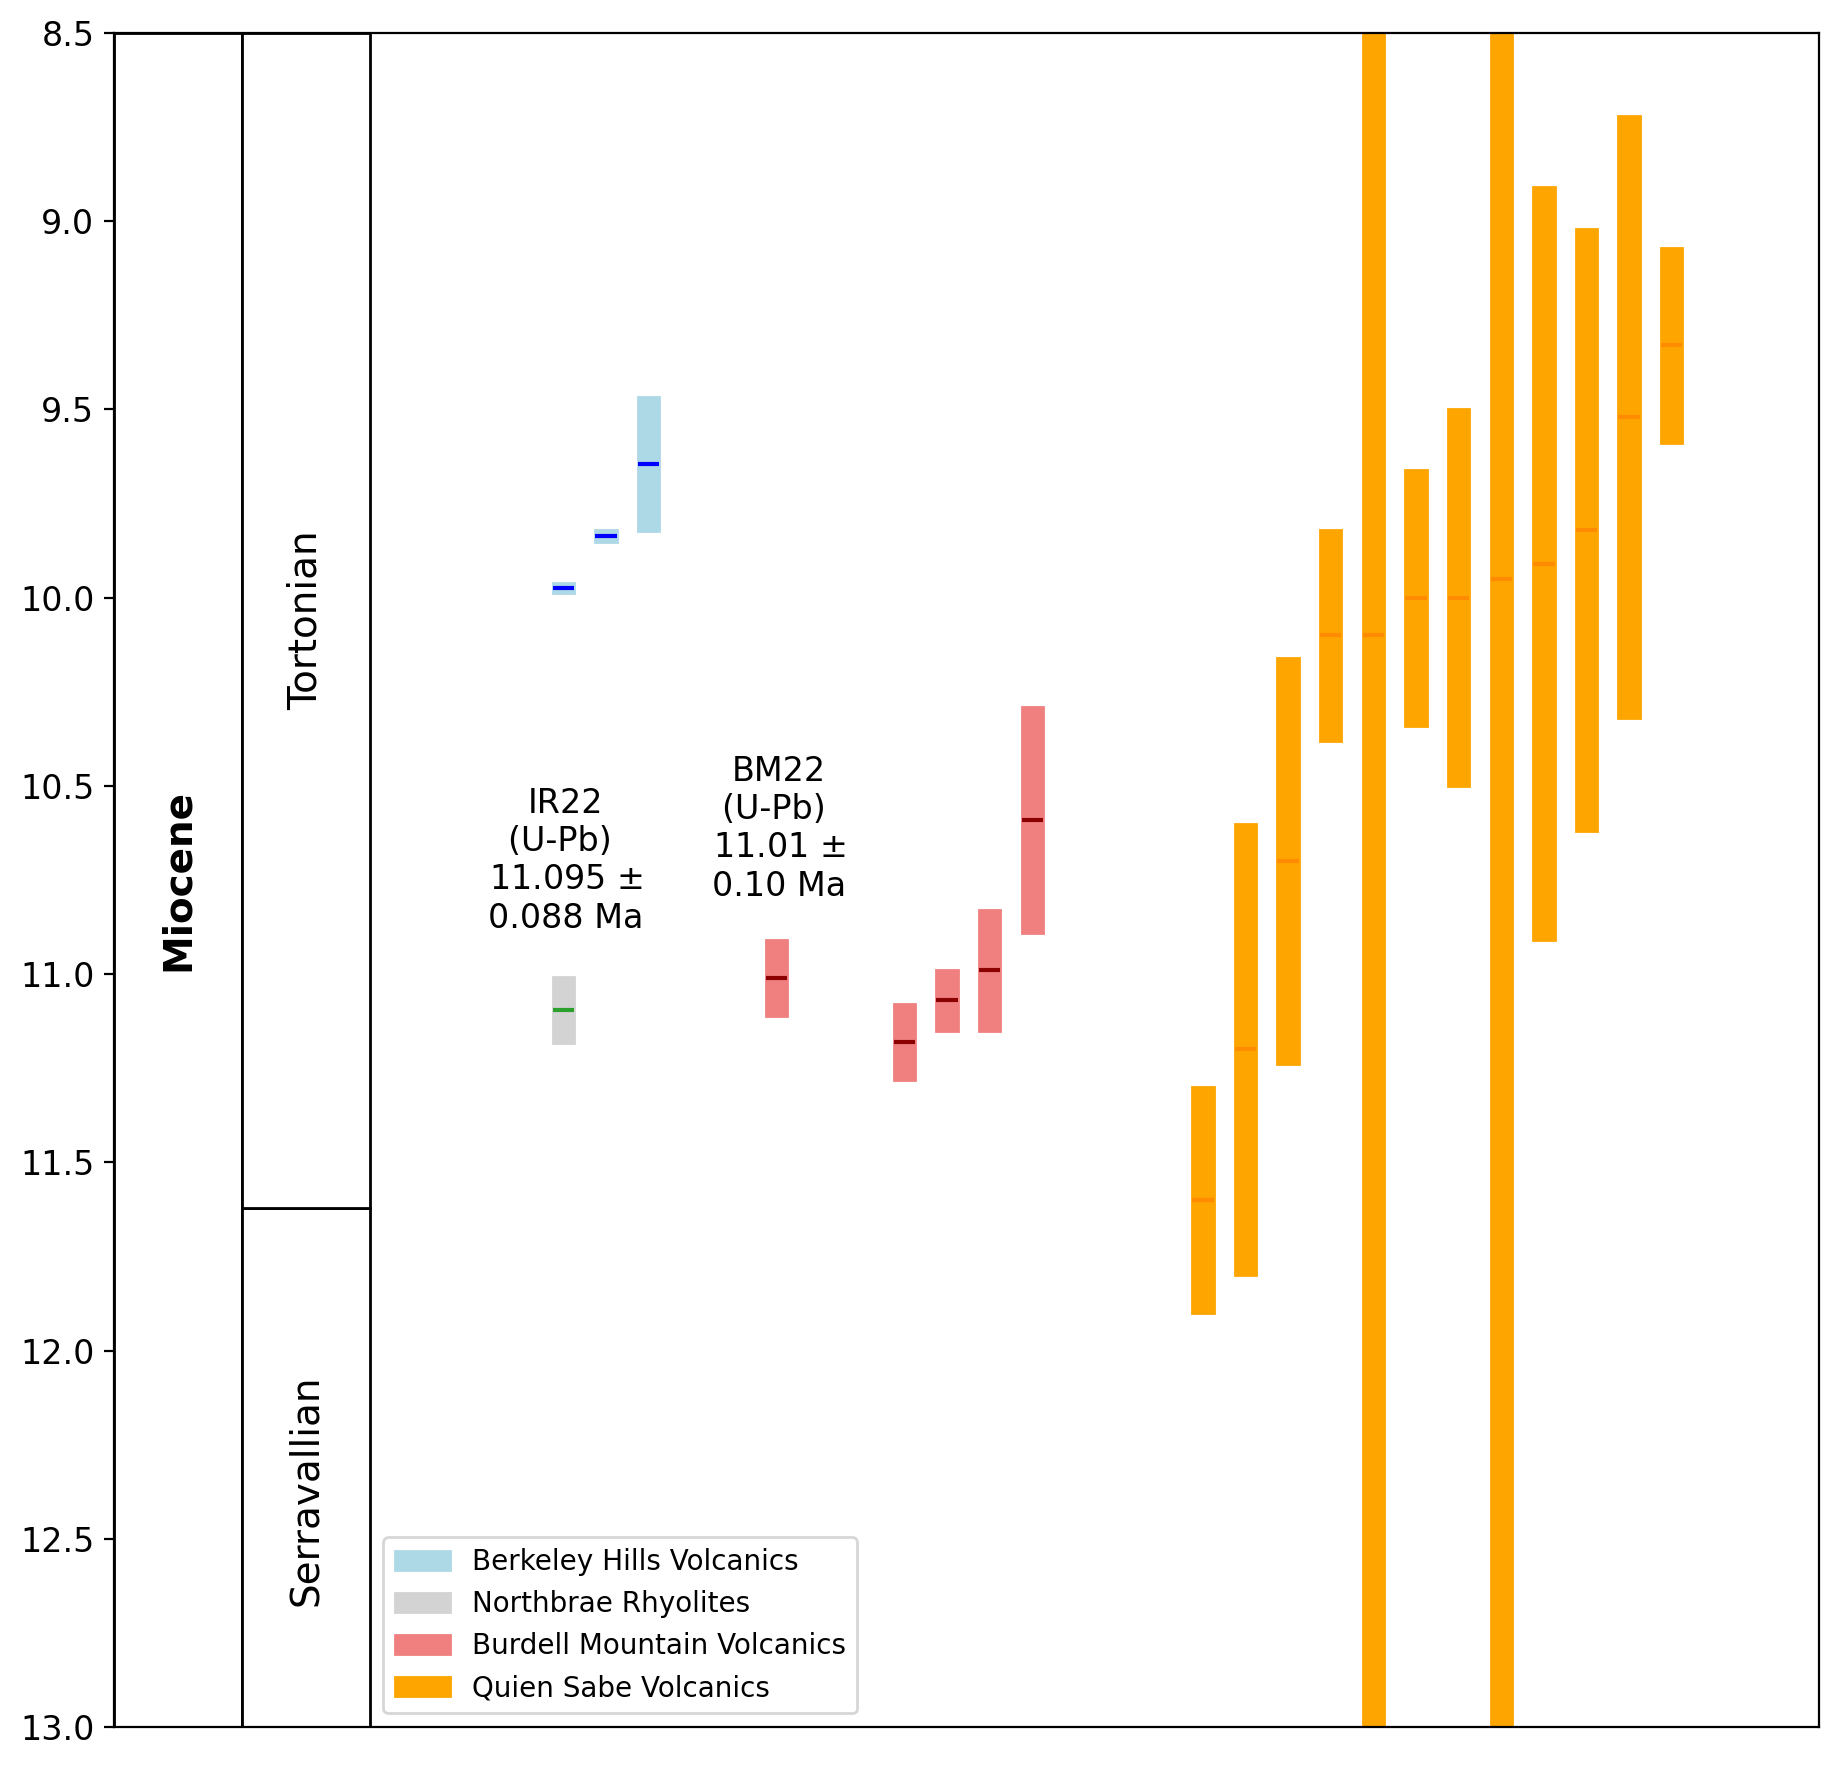

In [105]:
plot_age_min = 8.5
plot_age_max = 13

fig, ax = plt.subplots(figsize=(11,11))

Ar_width = 0.5

### Moraga Tuff dates
Ar_x=x_positions[0]-5

ax.hlines(MT24_1_Age,Ar_x,Ar_x+Ar_width,color='blue')

MT24_1_error = matplotlib.patches.Rectangle((Ar_x, MT24_1_Age-MT24_1_2Sigma),\
                                         Ar_width, MT24_1_2Sigma*2, color='lightblue', label='Berkeley Hills Volcanics')
ax.add_patch(MT24_1_error)
#ax.text(Ar_x+1,MT24_1_Age-0.2,'MT24-1\nMoraga Tuff\n(U-Pb) \n9.974 $\pm$\n0.014 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)


#fig, ax, x_positions = plot_dates(zircon_means, zircon_2sigmas, 
#                                  include, sample_means, sample_2sigmas, 
#                                  colors, labels, legend=False, figsize=(8.5,11),lineweight=6)


ax.set_ylim(plot_age_max,plot_age_min)
ax.set_xlim(-6,34)
ax.tick_params(axis='x', labelsize=13)
ax.set_xticks([])
# ax.text(x_positions[0]-(len(CSUF_4)/2),13.1,
#         'CSUF-4\nClaremont Fm\n(U-Pb)\n<13.298 $\pm$\n0.046 Ma',
#         size='12',horizontalalignment='center',
#         verticalalignment='bottom',multialignment='center',rotation=0)
# ax.text(x_positions[1]-(len(OR24_2)/2),OR24_2_date-0.2,
#         'OR24-2\nOrinda Tuff\nclast\n(U-Pb) \n10.094 $\pm$\n0.018 Ma',
#         size='12',horizontalalignment='center',
#         verticalalignment='bottom',multialignment='center',rotation=0)

#ax.text(x_positions[0]-(len(MT24_1)/2),MT24_1_date-0.2,
#        'MT24-1\nMoraga Tuff\n(U-Pb) \n9.974 $\pm$\n0.014 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)

### Moraga Tuff dates
Ar_x=x_positions[0]-4

ax.hlines(Moraga_Tuff_Ar_date,Ar_x,Ar_x+Ar_width,color='blue')

Moraga_Tuff_Ar_error = matplotlib.patches.Rectangle((Ar_x, Moraga_Tuff_Ar_date-Moraga_Tuff_Ar_2sigma),\
                                         Ar_width, Moraga_Tuff_Ar_2sigma*2, color='lightblue')
ax.add_patch(Moraga_Tuff_Ar_error)
#ax.text(Ar_x+1,Moraga_Tuff_Ar_date-0.2,'EBH15/\nBHR-1\nMoraga Tuff\n(Ar-Ar) \n9.836 $\pm$\n0.015 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)

### Siesta Tuff
Ar_x=x_positions[0]-3
ax.hlines(Siesta_Tuff_Ar_date,Ar_x,Ar_x+Ar_width,color='blue')

Siesta_Tuff_Ar_error = matplotlib.patches.Rectangle((Ar_x, Siesta_Tuff_Ar_date-Siesta_Tuff_Ar_2sigma),\
                                         Ar_width, Siesta_Tuff_Ar_2sigma*2, color='lightblue')
ax.add_patch(Siesta_Tuff_Ar_error)
#ax.text(Ar_x+1,Siesta_Tuff_Ar_date-0.2,'SFM-1\nSiesta Tuff\n(Ar-Ar) \n9.644 $\pm$\n0.178 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)

### Northbrae dates
Ar_x=x_positions[0]-5

ax.hlines(Indian_Rock_weighted_mean_date,Ar_x,Ar_x+Ar_width,color='C2')

Indian_Rock_date_error = matplotlib.patches.Rectangle((Ar_x, Indian_Rock_weighted_mean_date-Indian_Rock_weighted_mean_2sigma),\
                                         Ar_width, Indian_Rock_weighted_mean_2sigma*2, color='lightgrey', label='Northbrae Rhyolites')
ax.add_patch(Indian_Rock_date_error)
ax.text(Ar_x+0.3,Indian_Rock_weighted_mean_date-0.2,'IR22\n(U-Pb) \n11.095 $\pm$\n0.088 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

### Burdell dates
Ar_x=x_positions[0]

ax.hlines(Burdell_Mountain_weighted_mean_date,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_date_error = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_weighted_mean_date-Burdell_Mountain_weighted_mean_2sigma),\
                                         Ar_width, Burdell_Mountain_weighted_mean_2sigma*2, color='lightcoral', label='Burdell Mountain Volcanics')
ax.add_patch(Burdell_Mountain_date_error)
ax.text(Ar_x+0.3,Burdell_Mountain_weighted_mean_date-0.2,'BM22\n(U-Pb) \n11.01 $\pm$\n0.10 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

Ar_x=x_positions[0]+4

ax.hlines(Burdell_Mountain_Ar_date_RFBM_7,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_Ar_error_RFBM_7 = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_Ar_date_RFBM_7-Burdell_Mountain_Ar_2sigma_RFBM_7),\
                                         Ar_width, Burdell_Mountain_Ar_2sigma_RFBM_7*2, color='lightcoral')
ax.add_patch(Burdell_Mountain_Ar_error_RFBM_7)

Ar_x=x_positions[0]+5

ax.hlines(Burdell_Mountain_Ar_date_RFBM_8,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_Ar_error_RFBM_8 = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_Ar_date_RFBM_8-Burdell_Mountain_Ar_2sigma_RFBM_8),\
                                         Ar_width, Burdell_Mountain_Ar_2sigma_RFBM_8*2, color='lightcoral')
ax.add_patch(Burdell_Mountain_Ar_error_RFBM_8)

#ax.text(Ar_x+1,Burdell_Mountain_Ar_date_RFBM_8-0.2,'RFBM – 8\n(Ar-Ar) \n10.99 $\pm$\n0.16 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)

Ar_x=x_positions[0]+6

ax.hlines(Burdell_Mountain_Ar_date_RFBM_9,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_Ar_error_RFBM_9 = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_Ar_date_RFBM_9-Burdell_Mountain_Ar_2sigma_RFBM_9),\
                                         Ar_width, Burdell_Mountain_Ar_2sigma_RFBM_9*2, color='lightcoral')
ax.add_patch(Burdell_Mountain_Ar_error_RFBM_9)

Ar_x=x_positions[0]+3

ax.hlines(Burdell_Mountain_Ar_date_RFBM_10,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_Ar_error_RFBM_10 = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_Ar_date_RFBM_10-Burdell_Mountain_Ar_2sigma_RFBM_10),\
                                         Ar_width, Burdell_Mountain_Ar_2sigma_RFBM_10*2, color='lightcoral')
ax.add_patch(Burdell_Mountain_Ar_error_RFBM_10)



### Quien Sabe

Ar_x=x_positions[0]+21

ax.hlines(Quien_Sabe_K_Ar_date_85Sg_6,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_85Sg_6 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_85Sg_6-Quien_Sabe_K_Ar_2sigma_85Sg_6),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_85Sg_6*2, color='orange', label='Quien Sabe Volcanics')
ax.add_patch(Quien_Sabe_K_Ar_error_85Sg_6)

Ar_x=x_positions[0]+20

ax.hlines(Quien_Sabe_K_Ar_date_84Sg_8b,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_84Sg_8b = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_84Sg_8b-Quien_Sabe_K_Ar_2sigma_84Sg_8b),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_84Sg_8b*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_84Sg_8b)

Ar_x=x_positions[0]+19

ax.hlines(Quien_Sabe_K_Ar_date_84Sg_3,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_84Sg_3 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_84Sg_3-Quien_Sabe_K_Ar_2sigma_84Sg_3),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_84Sg_3*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_84Sg_3)

Ar_x=x_positions[0]+18

ax.hlines(Quien_Sabe_K_Ar_date_84Sg_6b,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_84Sg_6b = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_84Sg_6b-Quien_Sabe_K_Ar_2sigma_84Sg_6b),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_84Sg_6b*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_84Sg_6b)

Ar_x=x_positions[0]+17

ax.hlines(Quien_Sabe_K_Ar_date_84Sg_6a,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_84Sg_6a = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_84Sg_6a-Quien_Sabe_K_Ar_2sigma_84Sg_6a),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_84Sg_6a*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_84Sg_6a)

Ar_x=x_positions[0]+16

ax.hlines(Quien_Sabe_K_Ar_date_81JD_23,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_81JD_23 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_81JD_23-Quien_Sabe_K_Ar_2sigma_81JD_23),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_81JD_23*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_81JD_23)

Ar_x=x_positions[0]+15

ax.hlines(Quien_Sabe_K_Ar_date_86Sg_9,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_86Sg_9 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_86Sg_9-Quien_Sabe_K_Ar_2sigma_86Sg_9),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_86Sg_9*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_86Sg_9)

Ar_x=x_positions[0]+14

ax.hlines(Quien_Sabe_K_Ar_date_84Sg_8a,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_84Sg_8a = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_84Sg_8a-Quien_Sabe_K_Ar_2sigma_84Sg_8a),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_84Sg_8a*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_84Sg_8a)

Ar_x=x_positions[0]+13

ax.hlines(Quien_Sabe_K_Ar_date_86Sg_8,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_81Sg_8 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_86Sg_8-Quien_Sabe_K_Ar_2sigma_86Sg_8),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_86Sg_8*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_81Sg_8)

Ar_x=x_positions[0]+12

ax.hlines(Quien_Sabe_K_Ar_date_81JD_71,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_85JD_71 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_81JD_71-Quien_Sabe_K_Ar_2sigma_81JD_71),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_81JD_71*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_85JD_71)

Ar_x=x_positions[0]+11

ax.hlines(Quien_Sabe_K_Ar_date_89Sg_15,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_89Sg_15 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_89Sg_15-Quien_Sabe_K_Ar_2sigma_89Sg_15),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_89Sg_15*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_89Sg_15)

Ar_x=x_positions[0]+10

ax.hlines(Quien_Sabe_K_Ar_date_88Sg_12,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_88Sg_12 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_88Sg_12-Quien_Sabe_K_Ar_2sigma_88Sg_12),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_88Sg_12*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_88Sg_12)


#Ar_x=x_positions[0]+19

#ax.hlines(Quien_Sabe_K_Ar_date_85SG_6,Ar_x+3,Ar_x+Ar_width,color='black')
#ax.hlines(Quien_Sabe_K_Ar_date_88SG_12,Ar_x+3,Ar_x+Ar_width,color='black')
#ax.vlines(Ar_x+3,Quien_Sabe_K_Ar_date_85SG_6,Quien_Sabe_K_Ar_date_88SG_12,color='black')
#ax.text(Ar_x+7,(Quien_Sabe_K_Ar_date_85SG_6+Quien_Sabe_K_Ar_date_88SG_12)/2,'Active range\n of the\n Quien Sabe\n Volcanics',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)


ax.add_patch(matplotlib.patches.Rectangle((-6, plot_age_min), 3, 50, facecolor='white',edgecolor='black'))
ax.annotate('Miocene', (-4.5, (plot_age_max+plot_age_min)/2), color='black', weight='bold', 
            fontsize=14, ha='center', va='center',rotation=90)

#11.62 Serravallian - Tortonian boundary
#13.82 Langhian - Serravallian boundary
Serravallian_Tortonian = 11.62
Langhian_Serravallian = 13.82

ax.add_patch(matplotlib.patches.Rectangle((-3, Langhian_Serravallian), 
                                          3, 50, facecolor='white',edgecolor='black'))
ax.annotate('Langhian', (-1.5, (plot_age_max+Langhian_Serravallian)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

ax.add_patch(matplotlib.patches.Rectangle((-3, Serravallian_Tortonian), 
                                          3, Langhian_Serravallian-Serravallian_Tortonian, facecolor='white',edgecolor='black'))
ax.annotate('Serravallian', (-1.5, (Langhian_Serravallian+Serravallian_Tortonian-0.7)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

ax.add_patch(matplotlib.patches.Rectangle((-3, plot_age_min), 
                                          3, Serravallian_Tortonian-plot_age_min, facecolor='white',edgecolor='black'))
ax.annotate('Tortonian', (-1.5, (Serravallian_Tortonian+plot_age_min)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

plt.legend(loc='lower left',bbox_to_anchor=(0.15, 0., 0.5, 0.5))
plt.show()

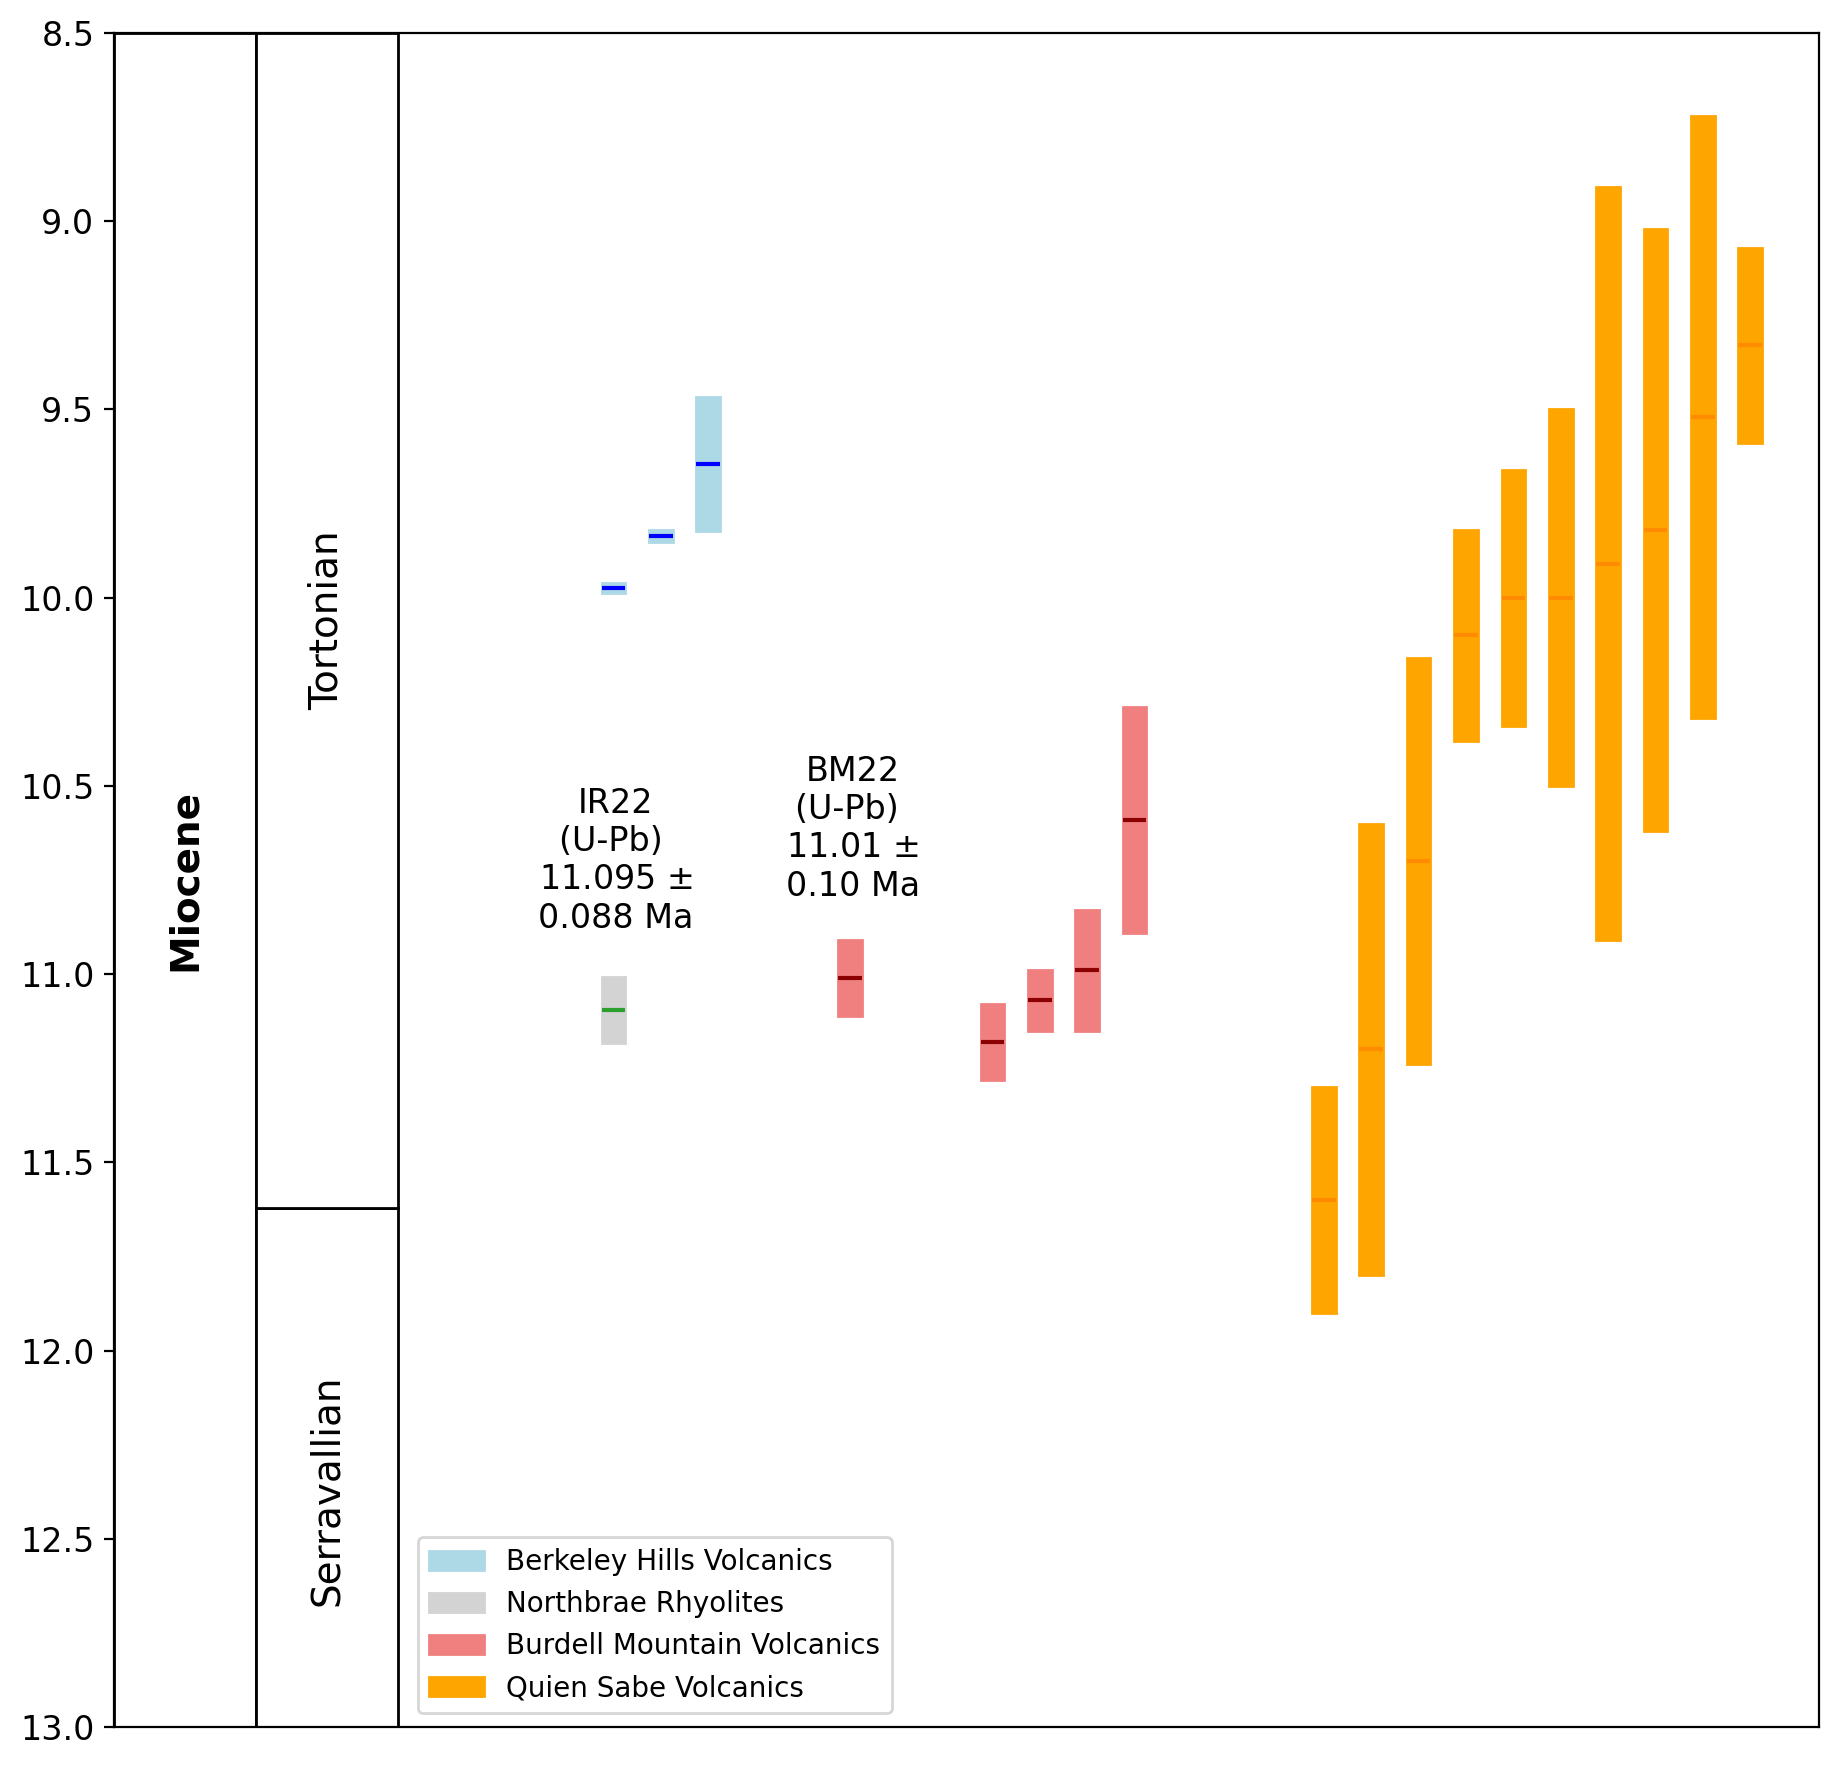

In [114]:
plot_age_min = 8.5
plot_age_max = 13

fig, ax = plt.subplots(figsize=(11,11))

Ar_width = 0.5

### Moraga Tuff dates
Ar_x=x_positions[0]-5

ax.hlines(MT24_1_Age,Ar_x,Ar_x+Ar_width,color='blue')

MT24_1_error = matplotlib.patches.Rectangle((Ar_x, MT24_1_Age-MT24_1_2Sigma),\
                                         Ar_width, MT24_1_2Sigma*2, color='lightblue', label='Berkeley Hills Volcanics')
ax.add_patch(MT24_1_error)
#ax.text(Ar_x+1,MT24_1_Age-0.2,'MT24-1\nMoraga Tuff\n(U-Pb) \n9.974 $\pm$\n0.014 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)


#fig, ax, x_positions = plot_dates(zircon_means, zircon_2sigmas, 
#                                  include, sample_means, sample_2sigmas, 
#                                  colors, labels, legend=False, figsize=(8.5,11),lineweight=6)


ax.set_ylim(plot_age_max,plot_age_min)
ax.set_xlim(-6,30)
ax.tick_params(axis='x', labelsize=13)
ax.set_xticks([])
# ax.text(x_positions[0]-(len(CSUF_4)/2),13.1,
#         'CSUF-4\nClaremont Fm\n(U-Pb)\n<13.298 $\pm$\n0.046 Ma',
#         size='12',horizontalalignment='center',
#         verticalalignment='bottom',multialignment='center',rotation=0)
# ax.text(x_positions[1]-(len(OR24_2)/2),OR24_2_date-0.2,
#         'OR24-2\nOrinda Tuff\nclast\n(U-Pb) \n10.094 $\pm$\n0.018 Ma',
#         size='12',horizontalalignment='center',
#         verticalalignment='bottom',multialignment='center',rotation=0)

#ax.text(x_positions[0]-(len(MT24_1)/2),MT24_1_date-0.2,
#        'MT24-1\nMoraga Tuff\n(U-Pb) \n9.974 $\pm$\n0.014 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)

### Moraga Tuff dates
Ar_x=x_positions[0]-4

ax.hlines(Moraga_Tuff_Ar_date,Ar_x,Ar_x+Ar_width,color='blue')

Moraga_Tuff_Ar_error = matplotlib.patches.Rectangle((Ar_x, Moraga_Tuff_Ar_date-Moraga_Tuff_Ar_2sigma),\
                                         Ar_width, Moraga_Tuff_Ar_2sigma*2, color='lightblue')
ax.add_patch(Moraga_Tuff_Ar_error)
#ax.text(Ar_x+1,Moraga_Tuff_Ar_date-0.2,'EBH15/\nBHR-1\nMoraga Tuff\n(Ar-Ar) \n9.836 $\pm$\n0.015 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)

### Siesta Tuff
Ar_x=x_positions[0]-3
ax.hlines(Siesta_Tuff_Ar_date,Ar_x,Ar_x+Ar_width,color='blue')

Siesta_Tuff_Ar_error = matplotlib.patches.Rectangle((Ar_x, Siesta_Tuff_Ar_date-Siesta_Tuff_Ar_2sigma),\
                                         Ar_width, Siesta_Tuff_Ar_2sigma*2, color='lightblue')
ax.add_patch(Siesta_Tuff_Ar_error)
#ax.text(Ar_x+1,Siesta_Tuff_Ar_date-0.2,'SFM-1\nSiesta Tuff\n(Ar-Ar) \n9.644 $\pm$\n0.178 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)

### Northbrae dates
Ar_x=x_positions[0]-5

ax.hlines(Indian_Rock_weighted_mean_date,Ar_x,Ar_x+Ar_width,color='C2')

Indian_Rock_date_error = matplotlib.patches.Rectangle((Ar_x, Indian_Rock_weighted_mean_date-Indian_Rock_weighted_mean_2sigma),\
                                         Ar_width, Indian_Rock_weighted_mean_2sigma*2, color='lightgrey', label='Northbrae Rhyolites')
ax.add_patch(Indian_Rock_date_error)
ax.text(Ar_x+0.3,Indian_Rock_weighted_mean_date-0.2,'IR22\n(U-Pb) \n11.095 $\pm$\n0.088 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

### Burdell dates
Ar_x=x_positions[0]

ax.hlines(Burdell_Mountain_weighted_mean_date,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_date_error = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_weighted_mean_date-Burdell_Mountain_weighted_mean_2sigma),\
                                         Ar_width, Burdell_Mountain_weighted_mean_2sigma*2, color='lightcoral', label='Burdell Mountain Volcanics')
ax.add_patch(Burdell_Mountain_date_error)
ax.text(Ar_x+0.3,Burdell_Mountain_weighted_mean_date-0.2,'BM22\n(U-Pb) \n11.01 $\pm$\n0.10 Ma',size='12',horizontalalignment='center',
        verticalalignment='bottom',multialignment='center',rotation=0)

Ar_x=x_positions[0]+4

ax.hlines(Burdell_Mountain_Ar_date_RFBM_7,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_Ar_error_RFBM_7 = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_Ar_date_RFBM_7-Burdell_Mountain_Ar_2sigma_RFBM_7),\
                                         Ar_width, Burdell_Mountain_Ar_2sigma_RFBM_7*2, color='lightcoral')
ax.add_patch(Burdell_Mountain_Ar_error_RFBM_7)

Ar_x=x_positions[0]+5

ax.hlines(Burdell_Mountain_Ar_date_RFBM_8,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_Ar_error_RFBM_8 = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_Ar_date_RFBM_8-Burdell_Mountain_Ar_2sigma_RFBM_8),\
                                         Ar_width, Burdell_Mountain_Ar_2sigma_RFBM_8*2, color='lightcoral')
ax.add_patch(Burdell_Mountain_Ar_error_RFBM_8)

#ax.text(Ar_x+1,Burdell_Mountain_Ar_date_RFBM_8-0.2,'RFBM – 8\n(Ar-Ar) \n10.99 $\pm$\n0.16 Ma',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)

Ar_x=x_positions[0]+6

ax.hlines(Burdell_Mountain_Ar_date_RFBM_9,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_Ar_error_RFBM_9 = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_Ar_date_RFBM_9-Burdell_Mountain_Ar_2sigma_RFBM_9),\
                                         Ar_width, Burdell_Mountain_Ar_2sigma_RFBM_9*2, color='lightcoral')
ax.add_patch(Burdell_Mountain_Ar_error_RFBM_9)

Ar_x=x_positions[0]+3

ax.hlines(Burdell_Mountain_Ar_date_RFBM_10,Ar_x,Ar_x+Ar_width,color='darkred')

Burdell_Mountain_Ar_error_RFBM_10 = matplotlib.patches.Rectangle((Ar_x, Burdell_Mountain_Ar_date_RFBM_10-Burdell_Mountain_Ar_2sigma_RFBM_10),\
                                         Ar_width, Burdell_Mountain_Ar_2sigma_RFBM_10*2, color='lightcoral')
ax.add_patch(Burdell_Mountain_Ar_error_RFBM_10)



### Quien Sabe

Ar_x=x_positions[0]+19

ax.hlines(Quien_Sabe_K_Ar_date_85Sg_6,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_85Sg_6 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_85Sg_6-Quien_Sabe_K_Ar_2sigma_85Sg_6),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_85Sg_6*2, color='orange', label='Quien Sabe Volcanics')
ax.add_patch(Quien_Sabe_K_Ar_error_85Sg_6)

Ar_x=x_positions[0]+18

ax.hlines(Quien_Sabe_K_Ar_date_84Sg_8b,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_84Sg_8b = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_84Sg_8b-Quien_Sabe_K_Ar_2sigma_84Sg_8b),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_84Sg_8b*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_84Sg_8b)

Ar_x=x_positions[0]+17

ax.hlines(Quien_Sabe_K_Ar_date_84Sg_3,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_84Sg_3 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_84Sg_3-Quien_Sabe_K_Ar_2sigma_84Sg_3),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_84Sg_3*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_84Sg_3)

Ar_x=x_positions[0]+16

ax.hlines(Quien_Sabe_K_Ar_date_84Sg_6b,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_84Sg_6b = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_84Sg_6b-Quien_Sabe_K_Ar_2sigma_84Sg_6b),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_84Sg_6b*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_84Sg_6b)

Ar_x=x_positions[0]+15

ax.hlines(Quien_Sabe_K_Ar_date_81JD_23,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_81JD_23 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_81JD_23-Quien_Sabe_K_Ar_2sigma_81JD_23),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_81JD_23*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_81JD_23)

Ar_x=x_positions[0]+14

ax.hlines(Quien_Sabe_K_Ar_date_86Sg_9,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_86Sg_9 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_86Sg_9-Quien_Sabe_K_Ar_2sigma_86Sg_9),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_86Sg_9*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_86Sg_9)

Ar_x=x_positions[0]+13

ax.hlines(Quien_Sabe_K_Ar_date_86Sg_8,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_81Sg_8 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_86Sg_8-Quien_Sabe_K_Ar_2sigma_86Sg_8),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_86Sg_8*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_81Sg_8)

Ar_x=x_positions[0]+12

ax.hlines(Quien_Sabe_K_Ar_date_81JD_71,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_85JD_71 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_81JD_71-Quien_Sabe_K_Ar_2sigma_81JD_71),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_81JD_71*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_85JD_71)

Ar_x=x_positions[0]+11

ax.hlines(Quien_Sabe_K_Ar_date_89Sg_15,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_89Sg_15 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_89Sg_15-Quien_Sabe_K_Ar_2sigma_89Sg_15),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_89Sg_15*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_89Sg_15)

Ar_x=x_positions[0]+10

ax.hlines(Quien_Sabe_K_Ar_date_88Sg_12,Ar_x,Ar_x+Ar_width,color='darkorange')

Quien_Sabe_K_Ar_error_88Sg_12 = matplotlib.patches.Rectangle((Ar_x, Quien_Sabe_K_Ar_date_88Sg_12-Quien_Sabe_K_Ar_2sigma_88Sg_12),\
                                         Ar_width, Quien_Sabe_K_Ar_2sigma_88Sg_12*2, color='orange')
ax.add_patch(Quien_Sabe_K_Ar_error_88Sg_12)


#Ar_x=x_positions[0]+19

#ax.hlines(Quien_Sabe_K_Ar_date_85SG_6,Ar_x+3,Ar_x+Ar_width,color='black')
#ax.hlines(Quien_Sabe_K_Ar_date_88SG_12,Ar_x+3,Ar_x+Ar_width,color='black')
#ax.vlines(Ar_x+3,Quien_Sabe_K_Ar_date_85SG_6,Quien_Sabe_K_Ar_date_88SG_12,color='black')
#ax.text(Ar_x+7,(Quien_Sabe_K_Ar_date_85SG_6+Quien_Sabe_K_Ar_date_88SG_12)/2,'Active range\n of the\n Quien Sabe\n Volcanics',size='12',horizontalalignment='center',
#        verticalalignment='bottom',multialignment='center',rotation=0)


ax.add_patch(matplotlib.patches.Rectangle((-6, plot_age_min), 3, 50, facecolor='white',edgecolor='black'))
ax.annotate('Miocene', (-4.5, (plot_age_max+plot_age_min)/2), color='black', weight='bold', 
            fontsize=14, ha='center', va='center',rotation=90)

#11.62 Serravallian - Tortonian boundary
#13.82 Langhian - Serravallian boundary
Serravallian_Tortonian = 11.62
Langhian_Serravallian = 13.82

ax.add_patch(matplotlib.patches.Rectangle((-3, Langhian_Serravallian), 
                                          3, 50, facecolor='white',edgecolor='black'))
ax.annotate('Langhian', (-1.5, (plot_age_max+Langhian_Serravallian)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

ax.add_patch(matplotlib.patches.Rectangle((-3, Serravallian_Tortonian), 
                                          3, Langhian_Serravallian-Serravallian_Tortonian, facecolor='white',edgecolor='black'))
ax.annotate('Serravallian', (-1.5, (Langhian_Serravallian+Serravallian_Tortonian-0.7)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

ax.add_patch(matplotlib.patches.Rectangle((-3, plot_age_min), 
                                          3, Serravallian_Tortonian-plot_age_min, facecolor='white',edgecolor='black'))
ax.annotate('Tortonian', (-1.5, (Serravallian_Tortonian+plot_age_min)/2), color='black', 
            fontsize=14, ha='center', va='center',rotation=90)

plt.legend(loc='lower left',bbox_to_anchor=(0.17, 0., 0.5, 0.5))
plt.show()